In [41]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

In [42]:
data_path = 'weather_data/testset.csv'

# create pandas dataframe
df = pd.read_csv(data_path)

# remove spaces on the column
df.columns = df.columns.str.lstrip()
df.columns = df.columns.str.rstrip()

# print out sample dataset
print(len(df))
df.head()

100990


,datetime_utc,_conds,_dewptm,_fog,_hail,_heatindexm,_hum,_precipm,_pressurem,_rain,_snow,_tempm,_thunder,_tornado,_vism,_wdird,_wdire,_wgustm,_windchillm,_wspdm
0,19961101-11:00,Smoke,9.0,0,0,NaN,27.0,NaN,1010.0,0,0,30.0,0,0,5.0,280.0,West,NaN,NaN,7.4
1,19961101-12:00,Smoke,10.0,0,0,NaN,32.0,NaN,-9999.0,0,0,28.0,0,0,NaN,0.0,North,NaN,NaN,NaN
2,19961101-13:00,Smoke,11.0,0,0,NaN,44.0,NaN,-9999.0,0,0,24.0,0,0,NaN,0.0,North,NaN,NaN,NaN
3,19961101-14:00,Smoke,10.0,0,0,NaN,41.0,NaN,1010.0,0,0,24.0,0,0,2.0,0.0,North,NaN,NaN,NaN
4,19961101-16:00,Smoke,11.0,0,0,NaN,47.0,NaN,1011.0,0,0,23.0,0,0,1.2,0.0,North,NaN,NaN,0.0


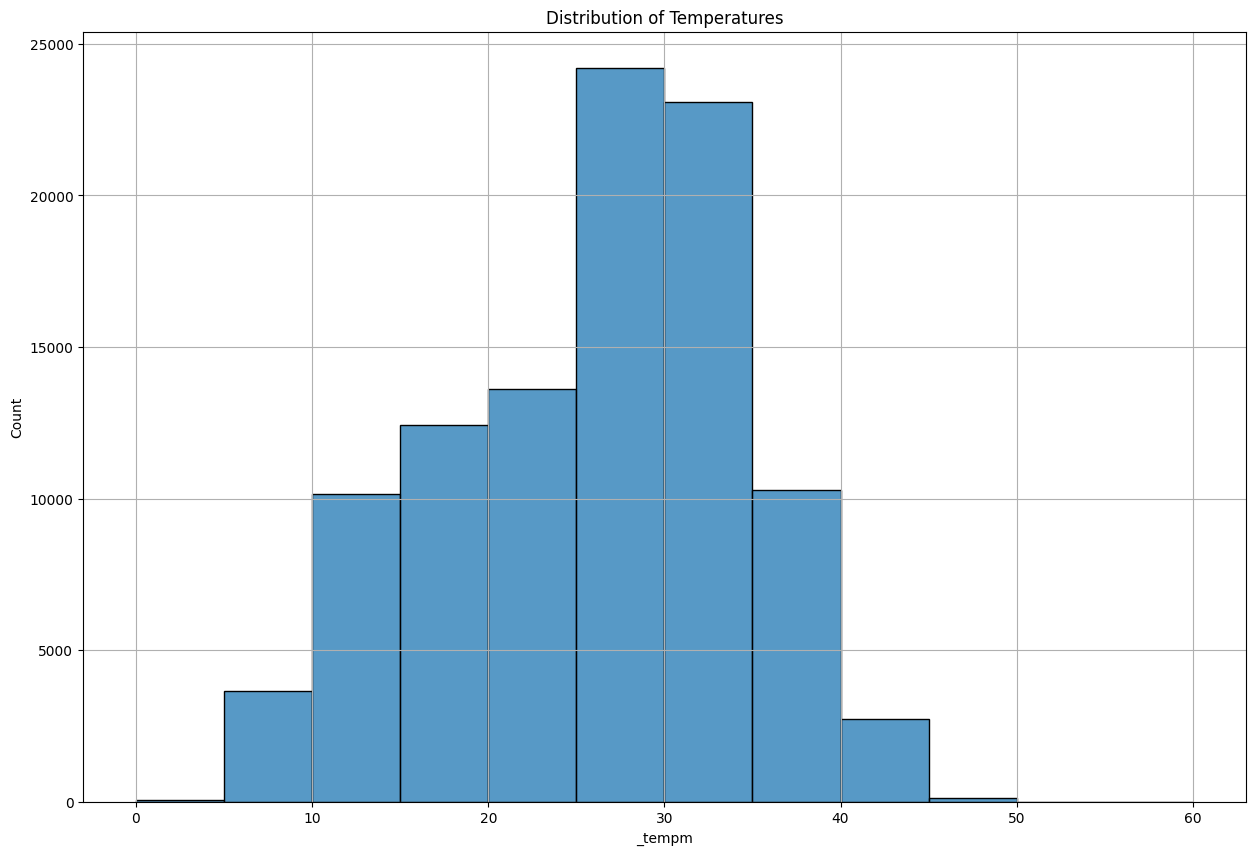

In [43]:
# plot to see the temperature varience
plt.figure(figsize=(15, 10))
sns.histplot(df['_tempm'],bins=[i for i in range(0,61,5)], kde=False)
plt.title("Distribution of Temperatures")
plt.grid()
plt.show()

In [44]:
# set data index as datetime column
df.index = pd.to_datetime(df.datetime_utc)

# filter the columns by only the required_columns
required_cols = ['_hum', '_rain', '_tempm']
df = df[required_cols]
df.head()

,_hum,_rain,_tempm
datetime_utc,,,
1996-11-01 11:00:00,27.0,0,30.0
1996-11-01 12:00:00,32.0,0,28.0
1996-11-01 13:00:00,44.0,0,24.0
1996-11-01 14:00:00,41.0,0,24.0
1996-11-01 16:00:00,47.0,0,23.0


In [45]:
# check number of nan values in dataframe
df.isna().sum()

_hum      757
_rain       0
_tempm    673
dtype: int64

In [46]:
# fill the nan values by upper row value
df = df.fillna(method='ffill')
df.tail()

C:\Users\Navod\AppData\Local\Temp\ipykernel_11852\923546998.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


,_hum,_rain,_tempm
datetime_utc,,,
2017-04-24 06:00:00,25.0,0,34.0
2017-04-24 09:00:00,16.0,0,38.0
2017-04-24 12:00:00,14.0,0,36.0
2017-04-24 15:00:00,27.0,0,32.0
2017-04-24 18:00:00,30.0,0,30.0


In [47]:
df_final = df.resample('D').mean()
df_final.head(10)

,_hum,_rain,_tempm
datetime_utc,,,
1996-11-01,52.916667,0.0,22.333333
1996-11-02,48.625000,0.0,22.916667
1996-11-03,55.958333,0.0,21.791667
1996-11-04,48.055556,0.0,22.722222
1996-11-05,29.400000,0.0,27.800000
1996-11-06,47.875000,0.0,21.937500
1996-11-07,48.000000,0.0,21.750000
1996-11-08,45.791667,0.0,21.000000
1996-11-09,47.181818,0.0,19.909091


In [48]:
df_final.isna().sum()

_hum      141
_rain     141
_tempm    141
dtype: int64

In [49]:
df_final = df_final.fillna(method='ffill')
df_final.isna().sum()

C:\Users\Navod\AppData\Local\Temp\ipykernel_11852\3141159991.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_final = df_final.fillna(method='ffill')


_hum      0
_rain     0
_tempm    0
dtype: int64

In [50]:

from sklearn.preprocessing import MinMaxScaler

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_final)

# Define sequence length and features
sequence_length = 7  # Number of time steps in each sequence
num_features = len(df_final.columns)

# Create sequences and corresponding labels
sequences = []
labels = []
for i in range(len(scaled_data) - sequence_length):
    seq = scaled_data[i:i+sequence_length]
    label = scaled_data[i+sequence_length][2]  # '_tempm' column index
    sequences.append(seq)
    labels.append(label)

# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Split into train and test sets
train_size = int(0.8 * len(sequences))
train_x, test_x = sequences[:train_size], sequences[train_size:]
train_y, test_y = labels[:train_size], labels[train_size:]

print("Train X shape:", train_x.shape)
print("Train Y shape:", train_y.shape)
print("Test X shape:", test_x.shape)
print("Test Y shape:", test_y.shape)


Train X shape: (5978, 7, 3)
Train Y shape: (5978,)
Test X shape: (1495, 7, 3)
Test Y shape: (1495,)


In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Create the LSTM model
model = Sequential()

# Add LSTM layers with dropout
model.add(LSTM(units=128, input_shape=(train_x.shape[1], train_x.shape[2]), return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=32, return_sequences=False))
model.add(Dropout(0.2))

# Add a dense output layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [53]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 7, 128)            67584     
                                                                 
 dropout_9 (Dropout)         (None, 7, 128)            0         
                                                                 
 lstm_10 (LSTM)              (None, 7, 64)             49408     
                                                                 
 dropout_10 (Dropout)        (None, 7, 64)             0         
                                                                 
 lstm_11 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_11 (Dropout)        (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [54]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('weather_pred_model/weather_pred_model_weights.h5', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(
    train_x, train_y,
    epochs=100,
    batch_size=64,
    validation_split=0.2,  # Use part of the training data as validation
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/100
75/75 [==============================] - 7s 31ms/step - loss: 0.0362 - val_loss: 0.0049
Epoch 2/100
 9/75 [==>...........................] - ETA: 1s - loss: 0.0095

c:\Users\Navod\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


75/75 [==============================] - 1s 18ms/step - loss: 0.0097 - val_loss: 0.0044
Epoch 3/100
75/75 [==============================] - 1s 18ms/step - loss: 0.0088 - val_loss: 0.0044
Epoch 4/100
75/75 [==============================] - 1s 18ms/step - loss: 0.0085 - val_loss: 0.0043
Epoch 5/100
75/75 [==============================] - 1s 18ms/step - loss: 0.0082 - val_loss: 0.0040
Epoch 6/100
75/75 [==============================] - 1s 18ms/step - loss: 0.0078 - val_loss: 0.0039
Epoch 7/100
75/75 [==============================] - 1s 18ms/step - loss: 0.0076 - val_loss: 0.0037
Epoch 8/100
75/75 [==============================] - 1s 17ms/step - loss: 0.0070 - val_loss: 0.0043
Epoch 9/100
75/75 [==============================] - 1s 18ms/step - loss: 0.0071 - val_loss: 0.0036
Epoch 10/100
75/75 [==============================] - 1s 17ms/step - loss: 0.0071 - val_loss: 0.0047
Epoch 11/100
75/75 [==============================] - 1s 19ms/step - loss: 0.0067 - val_loss: 0.0036
Epoch 12/1

In [55]:
# Evaluate the best model on the test set
best_model = tf.keras.models.load_model('weather_pred_model/weather_pred_model_weights.h5')
test_loss = best_model.evaluate(test_x, test_y)
print("Test Loss:", test_loss)

47/47 [==============================] - 1s 5ms/step - loss: 0.0020
Test Loss: 0.0020486388821154833


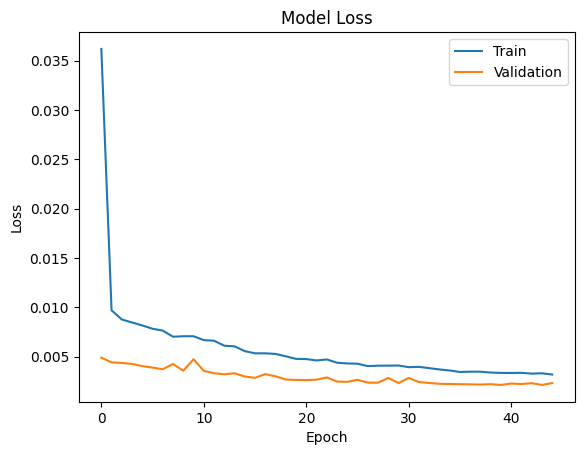

In [56]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [57]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Assuming you have trained the model and have the 'best_model' object
# Also, 'test_x' and 'test_y' should be available

# Predict temperatures using the trained model
predictions = best_model.predict(test_x)

# Calculate evaluation metrics
mae = mean_absolute_error(test_y, predictions)
mse = mean_squared_error(test_y, predictions)
rmse = np.sqrt(mse)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

47/47 [==============================] - 1s 6ms/step
Mean Absolute Error (MAE): 0.03468157718087304
Mean Squared Error (MSE): 0.002048639280978726
Root Mean Squared Error (RMSE): 0.045261896568512525


In [58]:
# y_true values
test_y_copies = np.repeat(test_y.reshape(-1, 1), test_x.shape[-1], axis=-1)
true_temp = scaler.inverse_transform(test_y_copies)[:,2]

# predicted values
prediction = best_model.predict(test_x)
prediction_copies = np.repeat(prediction, 3, axis=-1)
predicted_temp = scaler.inverse_transform(prediction_copies)[:,2]

47/47 [==============================] - 0s 5ms/step


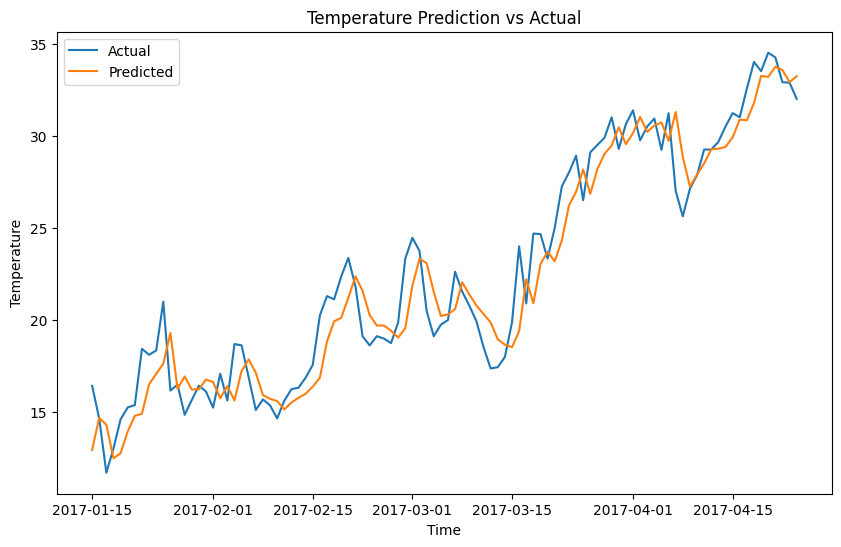

In [59]:
# Plotting predicted and actual temperatures
plt.figure(figsize=(10, 6))
plt.plot(df_final.index[-100:], true_temp[-100:], label='Actual')
plt.plot(df_final.index[-100:], predicted_temp[-100:], label='Predicted')
plt.title('Temperature Prediction vs Actual')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [60]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Normalize the data
scaler = MinMaxScaler()

data = np.array(df_final.head(7))  
scaled_data = scaler.fit_transform(data)
reshaped_data = np.expand_dims(scaled_data, axis=0)  # Add a batch dimension

best_model = tf.keras.models.load_model('weather_pred_model/weather_pred_model_weights.h5')
temp_on_8th_day = best_model.predict(reshaped_data)

# To revert the scaled temperatures:
temp_on_8th_day_copies = np.repeat(temp_on_8th_day, 3, axis=-1)
predicted_temp = scaler.inverse_transform(temp_on_10th_day_copies)[:,2]

print(temp_on_8th_day)
print(predicted_temp)

1/1 [==============================] - 1s 901ms/step
[[0.10272664]]
[22.400414]
